# ラベル毎にデータを眺めるnotebook

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
%cd gdrive/My\ Drive/KKB-kaggle/bengaliai-cv19/notebooks

/content/gdrive/My Drive/KKB-kaggle/bengaliai-cv19/notebooks


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
import copy
import torch

In [0]:
dataset_dir = '../dataset'
train_df = pd.read_csv(dataset_dir + '/train.csv')
test_df = pd.read_csv(dataset_dir + '/test.csv')
class_map_df = pd.read_csv(dataset_dir + '/class_map.csv')
sample_sub_df = pd.read_csv(dataset_dir + '/sample_submission.csv')

In [5]:
# 各grapheme_root, consonant_diacritic, vowel_diacriticが何回出現しているのかを調べたい
# それぞれのgrapheme_root, consonant_diacritic, vowel_diacriticについての情報をまとめるDataFrameを作成する

root_df = class_map_df[class_map_df['component_type']=='grapheme_root']
print(f'Size: {root_df.shape}')
cons_df = class_map_df[class_map_df['component_type']=='consonant_diacritic'].reset_index(drop=True)
print(f'Size: {cons_df.shape}')
vowel_df = class_map_df[class_map_df['component_type']=='vowel_diacritic'].reset_index(drop=True)
print(f'Size: {vowel_df.shape}')

Size: (168, 3)
Size: (7, 3)
Size: (11, 3)


In [6]:
root_df.drop(columns=['component_type'], inplace=True)
cons_df.drop(columns=['component_type'], inplace=True)
vowel_df.drop(columns=['component_type'], inplace=True)
root_df['count'] = train_df.groupby(['grapheme_root']).size()
cons_df['count'] = train_df.groupby(['consonant_diacritic']).size()
vowel_df['count'] = train_df.groupby(['vowel_diacritic']).size()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [7]:
root_df

label component  count
0        0         ং    147
1        1         ঃ    145
2        2         অ    337
3        3         আ    318
4        4         ই    331
..     ...       ...    ...
163    163       হ্ল    165
164    164         ৎ    164
165    165         ড়   1142
166    166         ঢ়    307
167    167         য়   1585

[168 rows x 3 columns]

In [8]:
cons_df

label component   count
0      0         0  125278
1      1         ঁ    7424
2      2        র্   23465
3      3       র্য     619
4      4        ্য   21270
5      5        ্র   21397
6      6      ্র্য    1387

In [9]:
vowel_df

label component  count
0       0         0  41508
1       1         া  36886
2       2         ি  25967
3       3         ী  16152
4       4         ু  18848
5       5         ূ   5297
6       6         ৃ   4336
7       7         ে  28723
8       8         ৈ   3528
9       9         ো  16032
10     10         ৌ   3563

In [0]:
#train_image_data_1.parquetの画像だけでみてみる
train_df_with_img = pd.merge(pd.read_parquet(dataset_dir + '/train_image_data_1.parquet'), train_df, on='image_id').drop(['image_id'], axis=1)

In [11]:
# 画像は '0' から '32331' に格納された。　32332 = 137 x 236
train_df_with_img.head()

0    1    2  ...  vowel_diacritic  consonant_diacritic  grapheme
0  246  253  251  ...                0                    2     র্দ্দ
1  250  245  241  ...                2                    0      গ্লি
2  248  248  249  ...                3                    5    ন্ত্রী
3  253  252  250  ...                8                    0      দ্বৈ
4  250  252  252  ...               10                    1       পৌঁ

[5 rows x 32336 columns]

## 画像を眺める

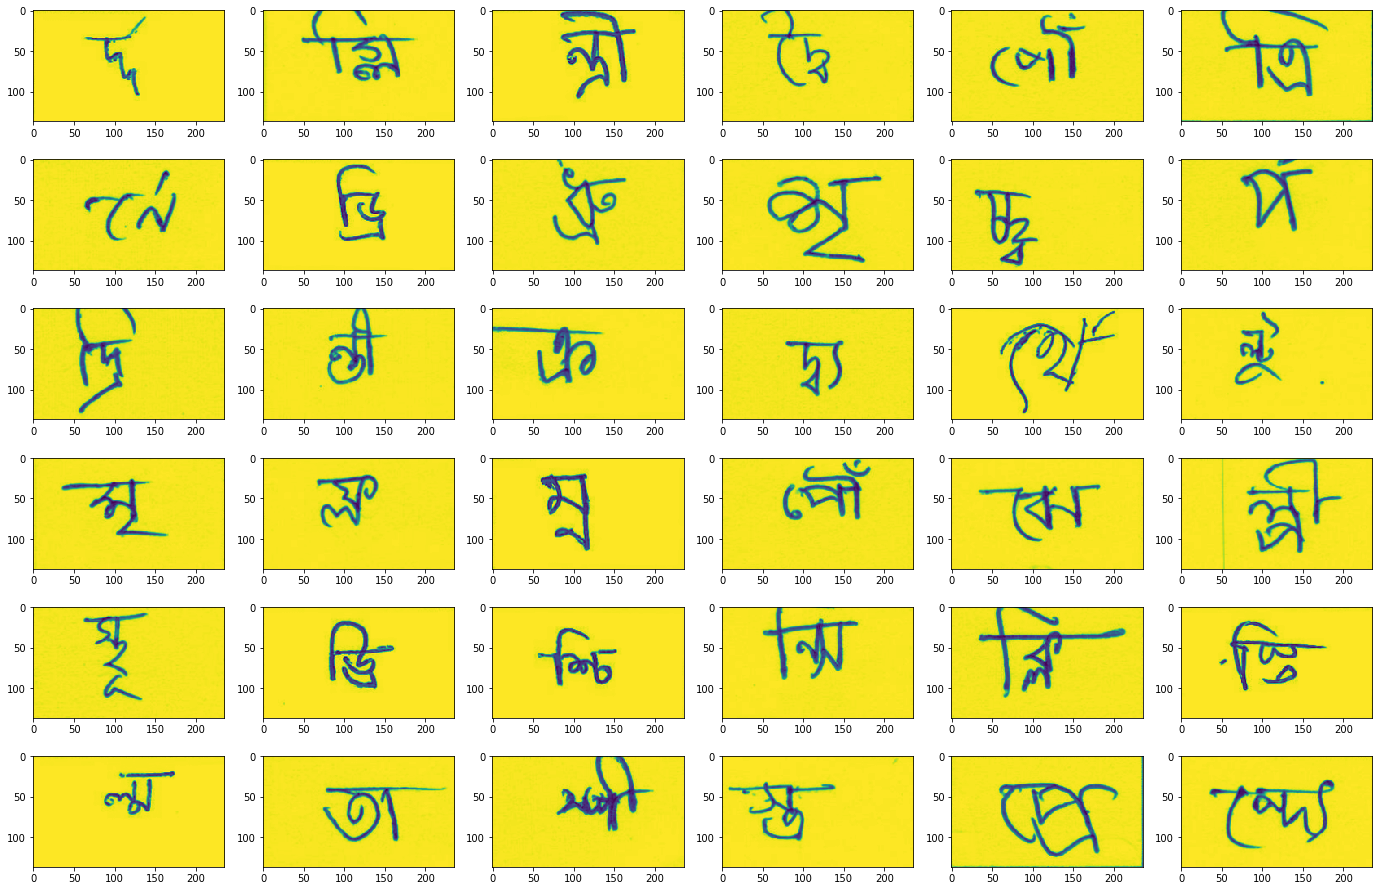

In [12]:
# とりあえず最初の36個をみる。（寺島のと同じ）
HEIGHT = 137
WIDTH = 236

X_train = train_df_with_img.drop(columns=['grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'grapheme'])

# 元画像を表示
# ピクセル値が255に近いほど黄色、0に近いほど濃色
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(24, 16))
count=0
for row in ax:
    for col in row:
        col.imshow(X_train.iloc[[count]].values.reshape(HEIGHT, WIDTH))
        count += 1
plt.show()

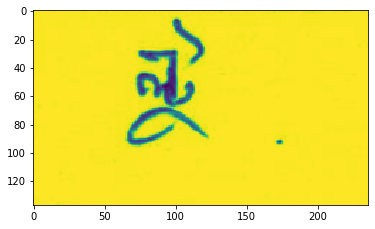

In [13]:
plt.imshow(X_train.iloc[[17]].values.reshape(HEIGHT, WIDTH))

こんな感じでノイズみたいなのが入っているのもあるし、途中で切れてしまっているものもある。

### grapheme_root毎にみてみる

ং


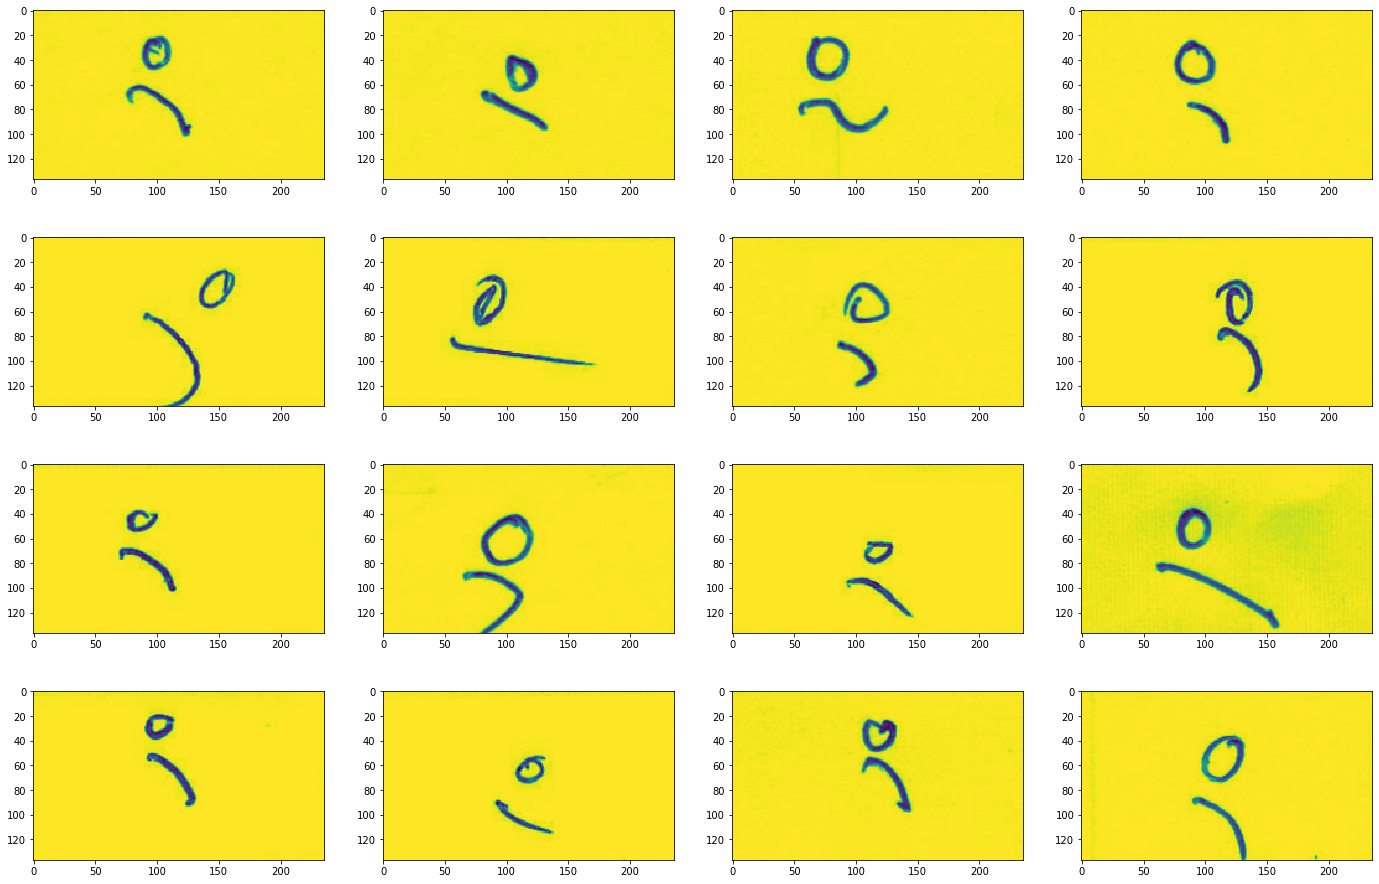

In [16]:
num = 0

print(root_df.iloc[num]['component'])

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(24, 16))

count =0
for row in ax:
    for col in row:
        col.imshow(train_df_with_img[train_df_with_img['grapheme_root'] == num].drop(columns=['grapheme']).iloc[count].values[:-3].reshape(HEIGHT,WIDTH))
        count += 1
plt.show()


ঃ


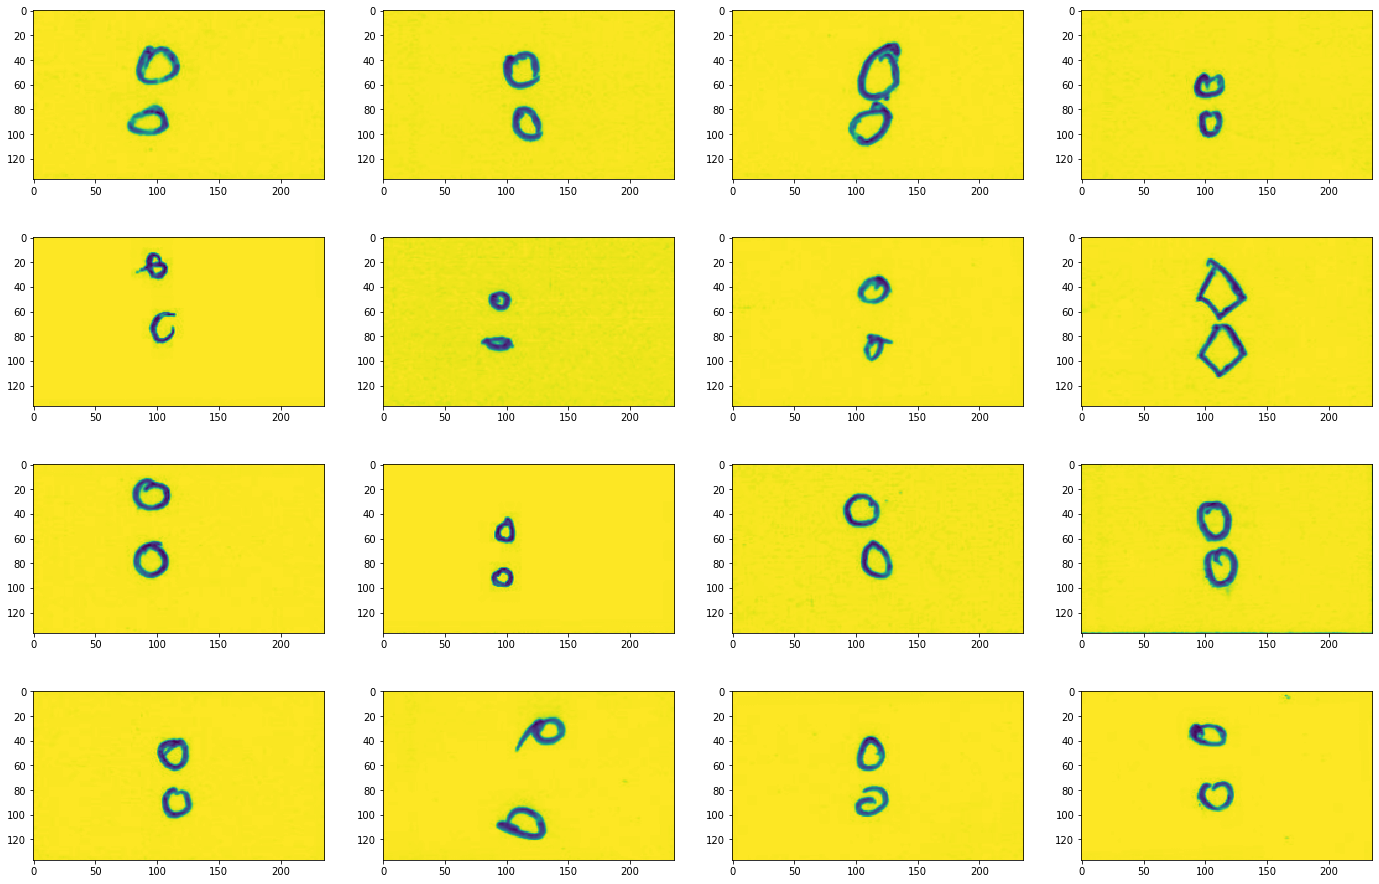

In [17]:
num = 1

print(root_df.iloc[num]['component'])

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(24, 16))

count =0
for row in ax:
    for col in row:
        col.imshow(train_df_with_img[train_df_with_img['grapheme_root'] == num].drop(columns=['grapheme']).iloc[count].values[:-3].reshape(HEIGHT,WIDTH))
        count += 1
plt.show()


অ


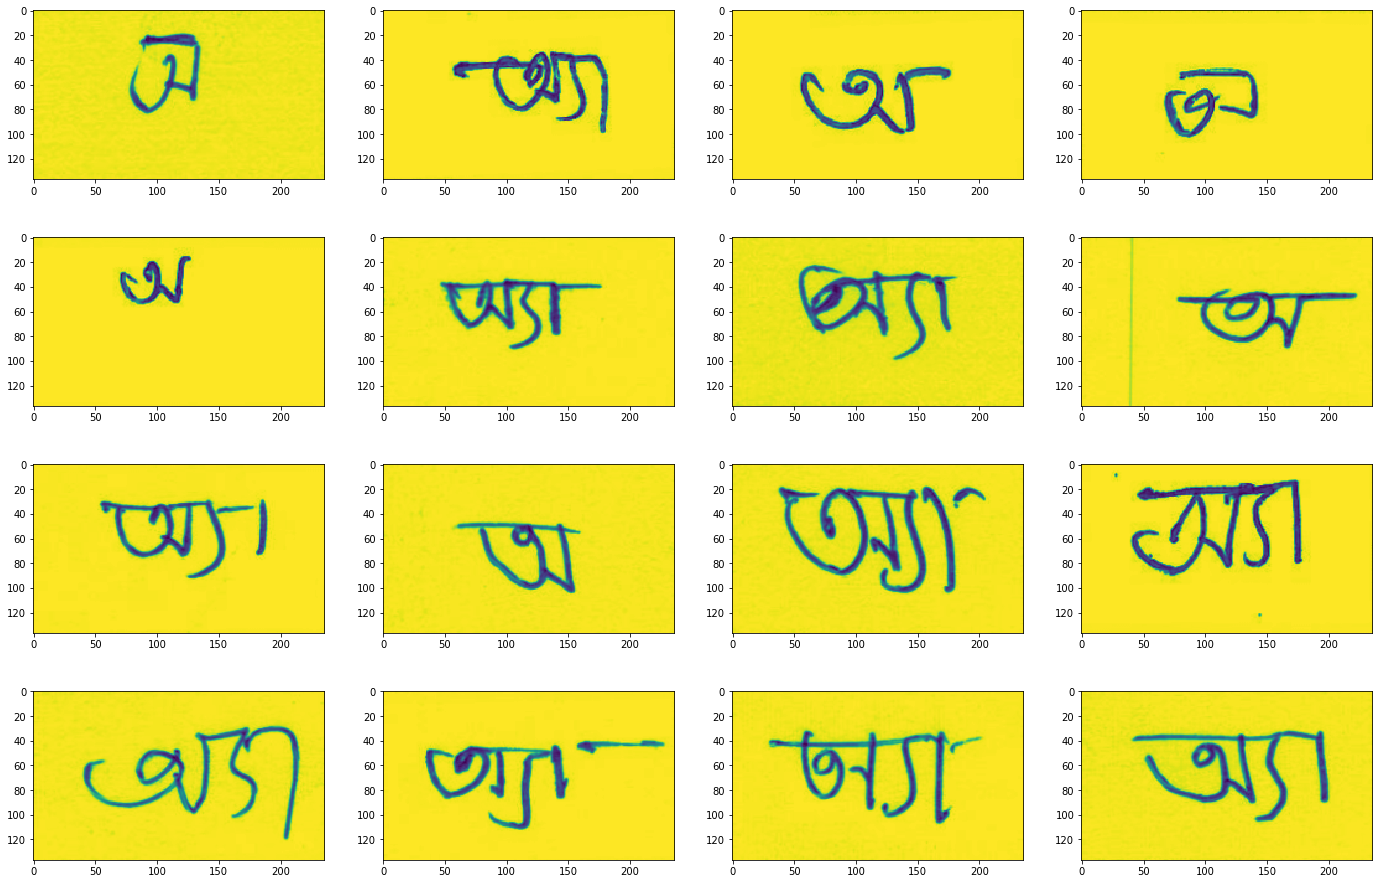

In [18]:
num = 2

print(root_df.iloc[num]['component'])

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(24, 16))

count =0
for row in ax:
    for col in row:
        col.imshow(train_df_with_img[train_df_with_img['grapheme_root'] == num].drop(columns=['grapheme']).iloc[count].values[:-3].reshape(HEIGHT,WIDTH))
        count += 1
plt.show()


আ


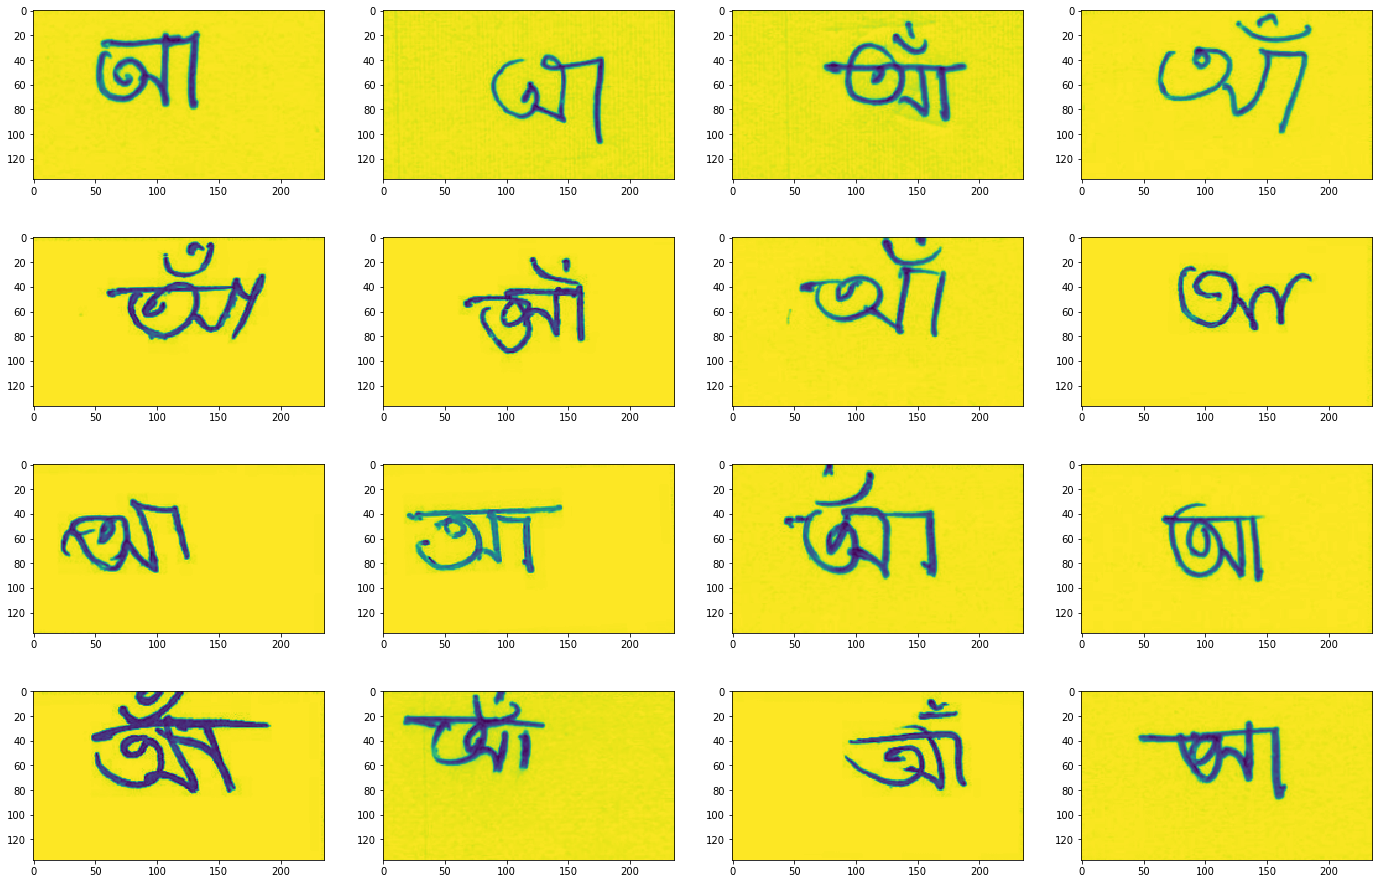

In [19]:
num = 3

print(root_df.iloc[num]['component'])

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(24, 16))

count =0
for row in ax:
    for col in row:
        col.imshow(train_df_with_img[train_df_with_img['grapheme_root'] == num].drop(columns=['grapheme']).iloc[count].values[:-3].reshape(HEIGHT,WIDTH))
        count += 1
plt.show()


ই


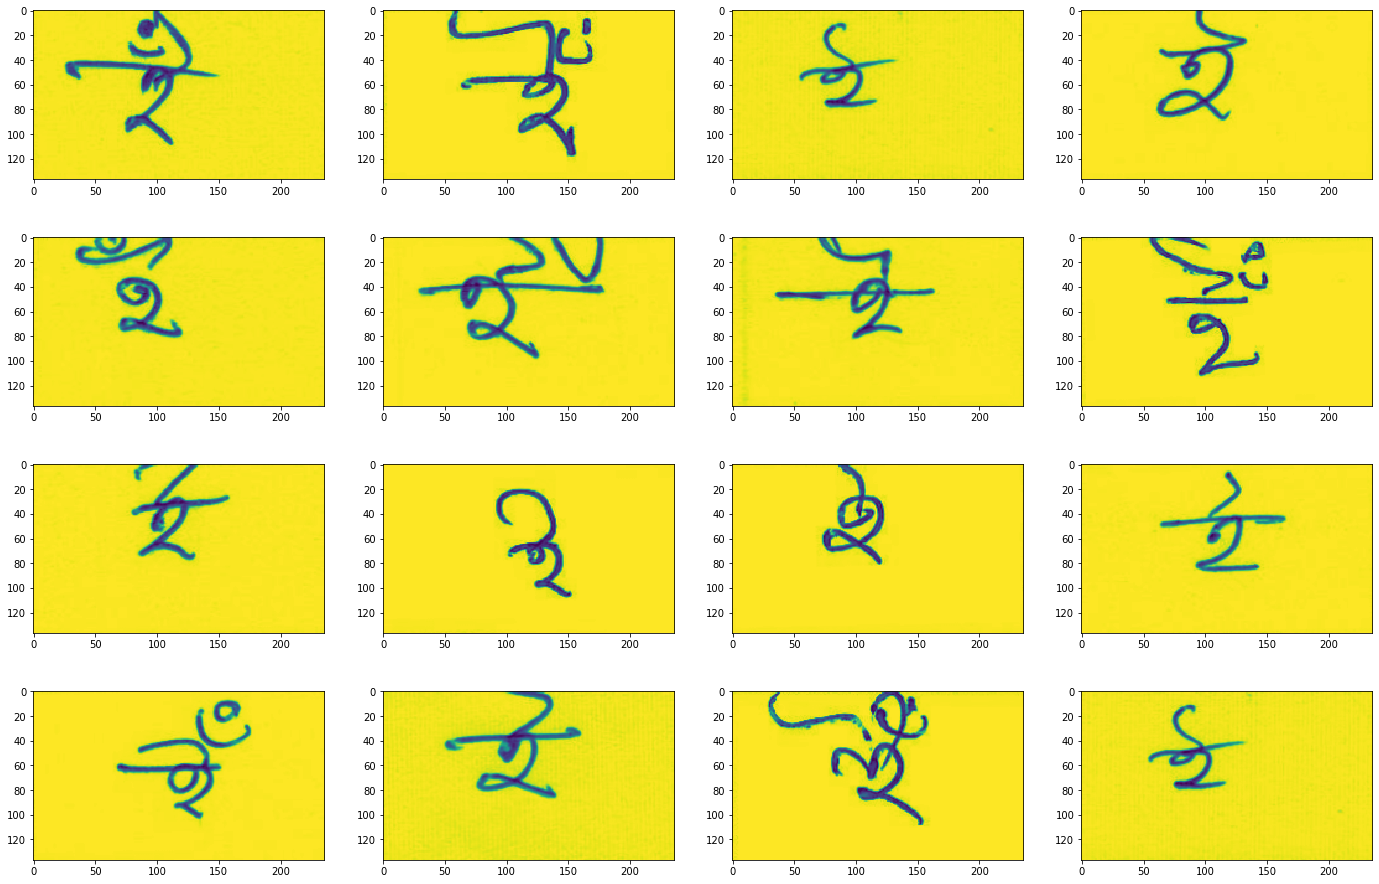

In [20]:
num = 4

print(root_df.iloc[num]['component'])

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(24, 16))

count =0
for row in ax:
    for col in row:
        col.imshow(train_df_with_img[train_df_with_img['grapheme_root'] == num].drop(columns=['grapheme']).iloc[count].values[:-3].reshape(HEIGHT,WIDTH))
        count += 1
plt.show()


同じgrapheme_rootの文字でも、他の要素の記号とか人による書き方でだいぶ形がちがう。

### vowel_diacritic毎にみてみる

0


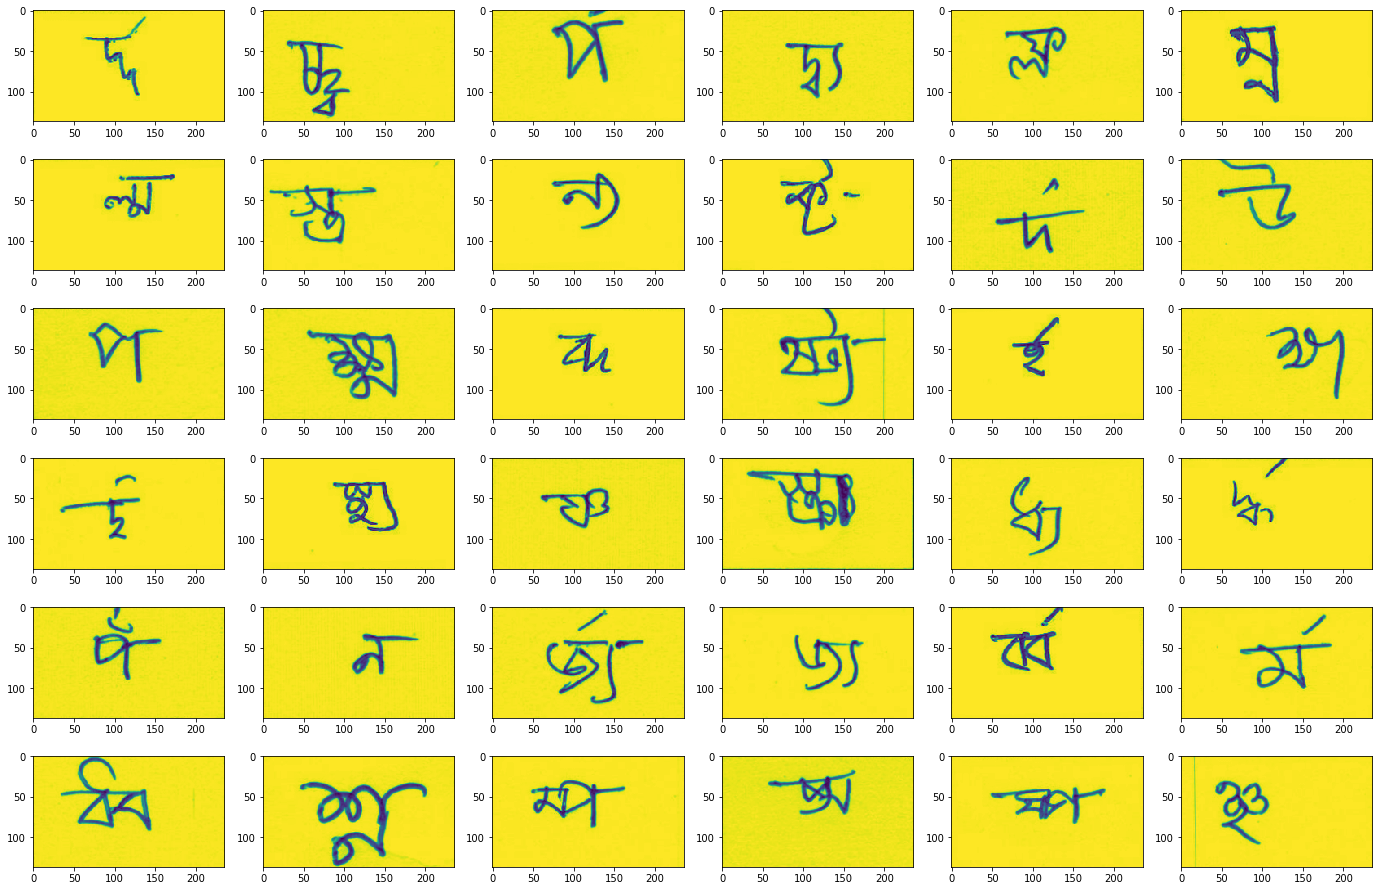

In [23]:
num = 0

print(vowel_df.iloc[num]['component'])

fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(24, 16))

count =0
for row in ax:
    for col in row:
        col.imshow(train_df_with_img[train_df_with_img['vowel_diacritic'] == num].drop(columns=['grapheme']).iloc[count].values[:-3].reshape(HEIGHT,WIDTH))
        count += 1
plt.show()


া


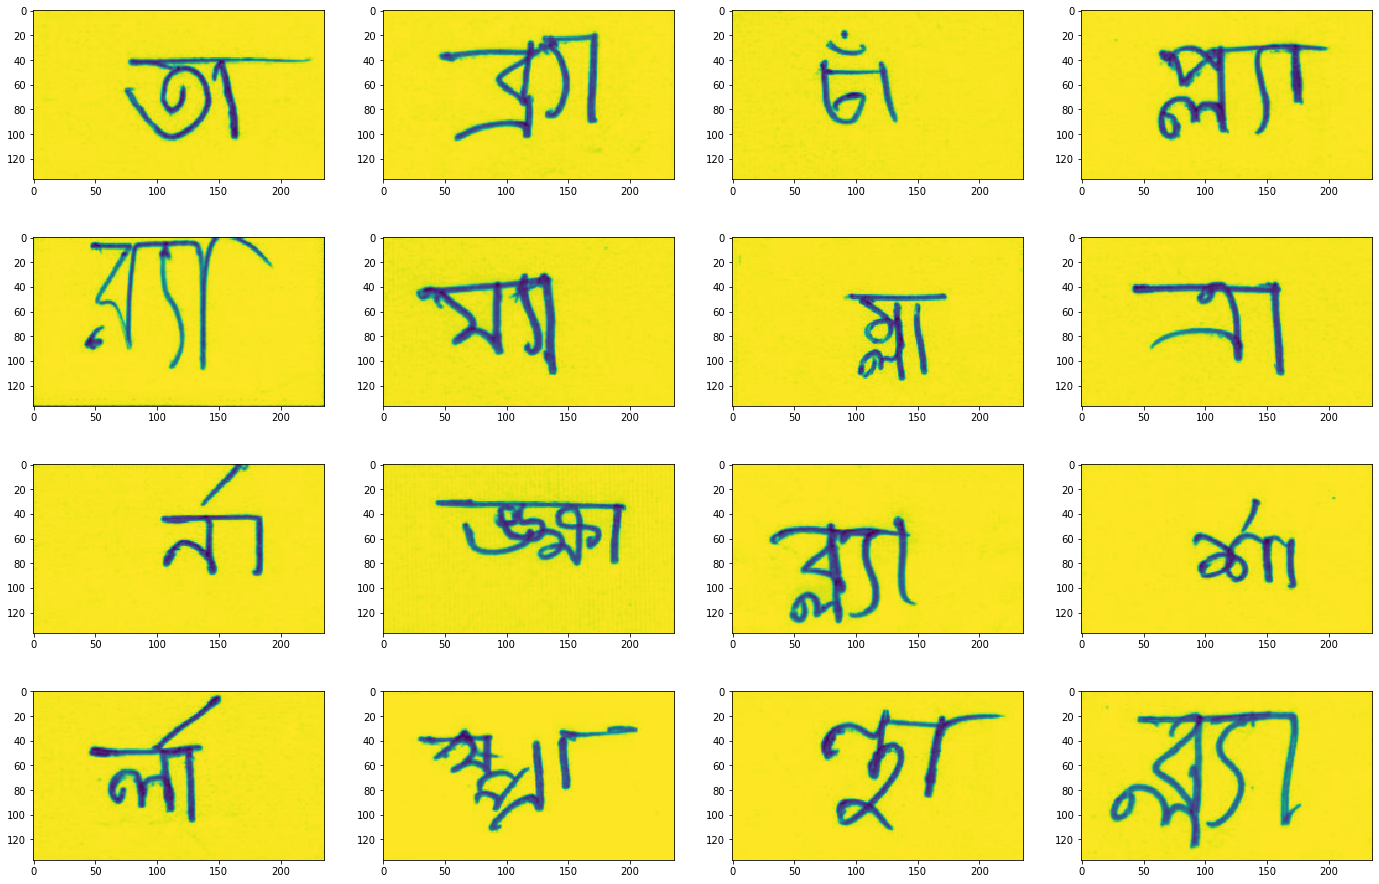

In [24]:
num = 1

print(vowel_df.iloc[num]['component'])

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(24, 16))

count =0
for row in ax:
    for col in row:
        col.imshow(train_df_with_img[train_df_with_img['vowel_diacritic'] == num].drop(columns=['grapheme']).iloc[count].values[:-3].reshape(HEIGHT,WIDTH))
        count += 1
plt.show()


ি


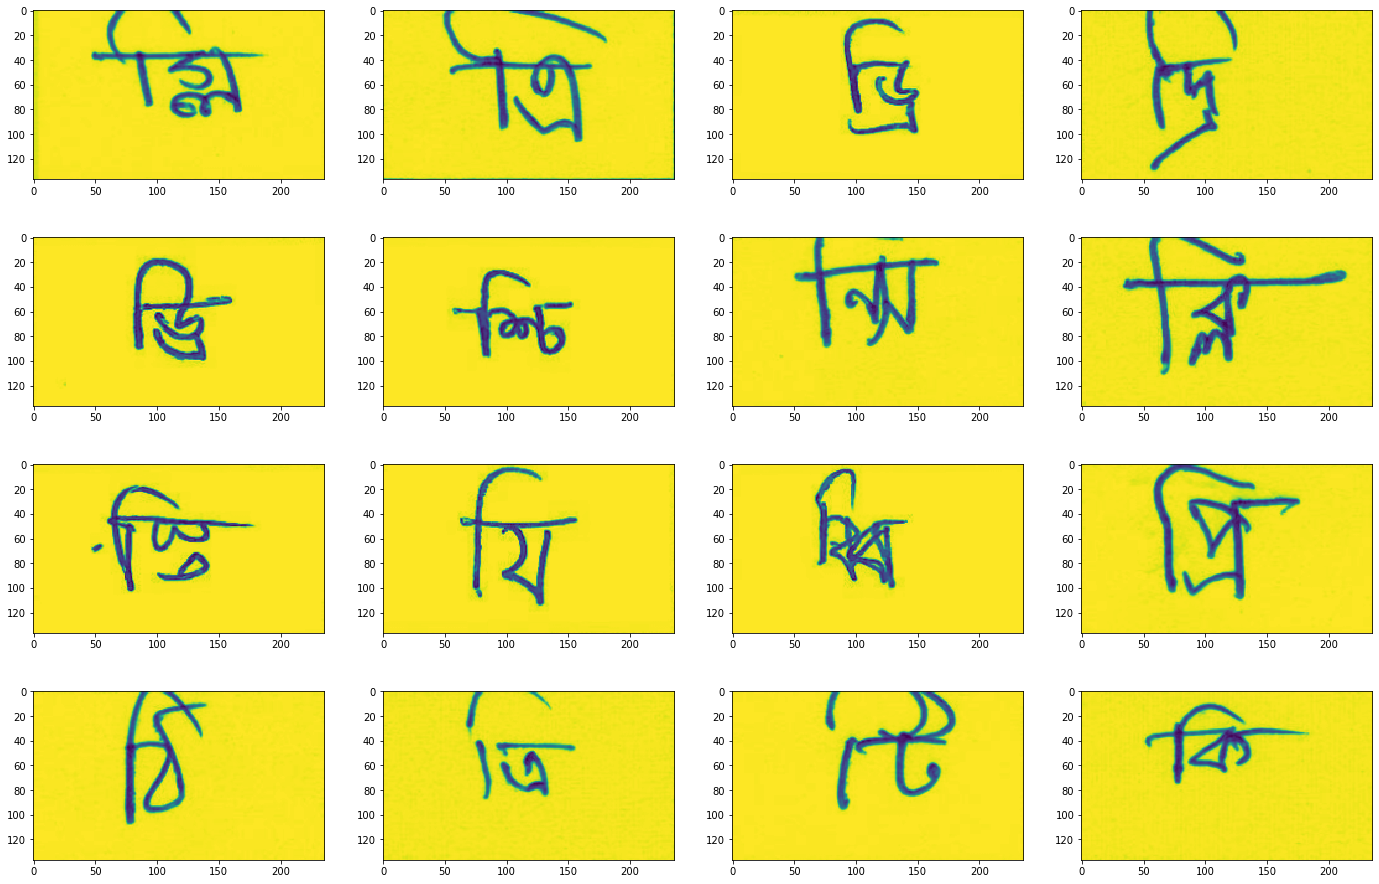

In [25]:
num = 2

print(vowel_df.iloc[num]['component'])

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(24, 16))

count =0
for row in ax:
    for col in row:
        col.imshow(train_df_with_img[train_df_with_img['vowel_diacritic'] == num].drop(columns=['grapheme']).iloc[count].values[:-3].reshape(HEIGHT,WIDTH))
        count += 1
plt.show()


ী


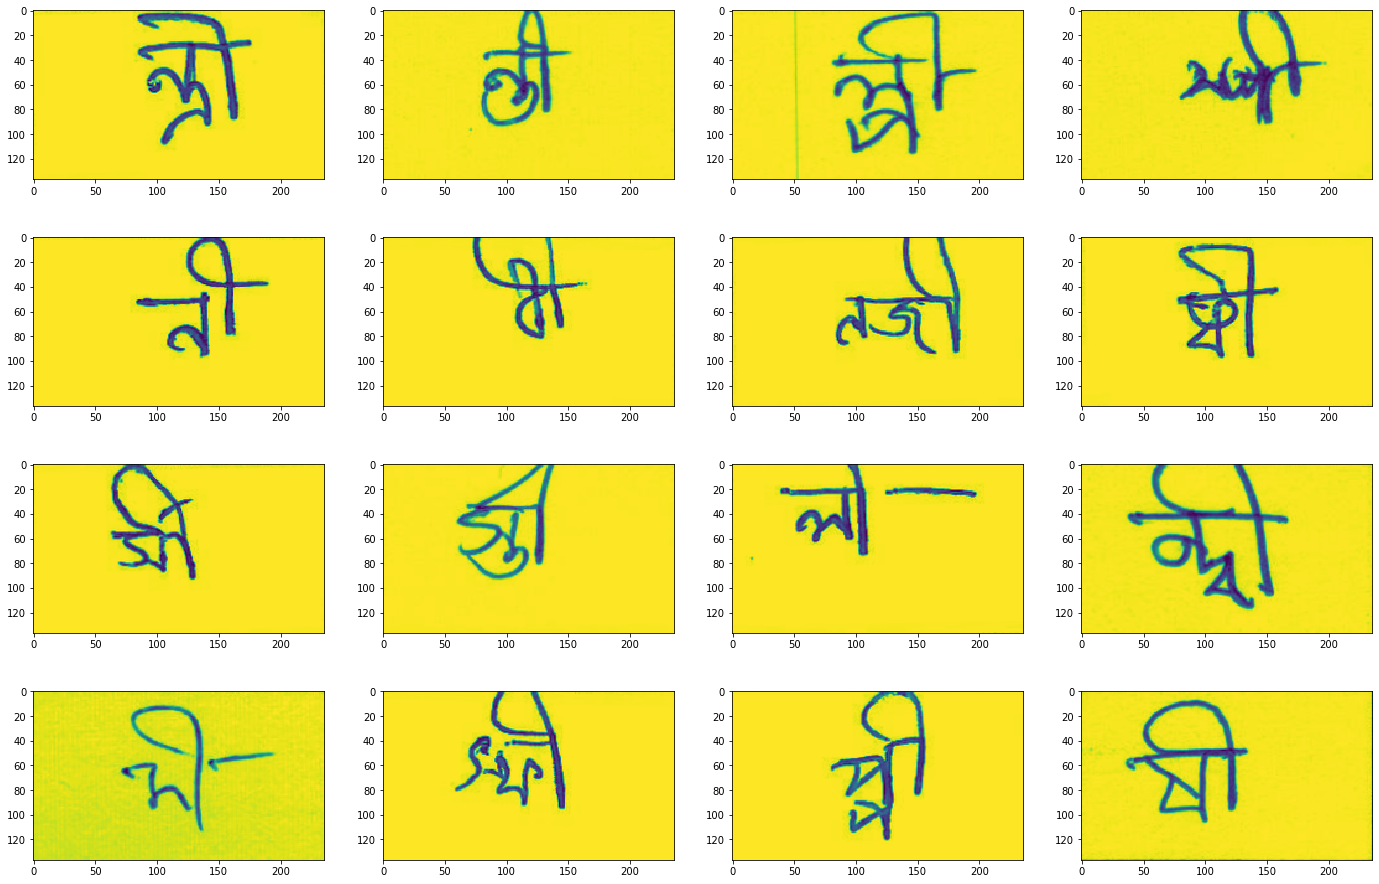

In [27]:
num = 3

print(vowel_df.iloc[num]['component'])

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(24, 16))

count =0
for row in ax:
    for col in row:
        col.imshow(train_df_with_img[train_df_with_img['vowel_diacritic'] == num].drop(columns=['grapheme']).iloc[count].values[:-3].reshape(HEIGHT,WIDTH))
        count += 1
plt.show()


とくに最後のやつとか画像に欠損があると結構難しそうに思える。  

### consonant_diacritic毎にみてみる

0


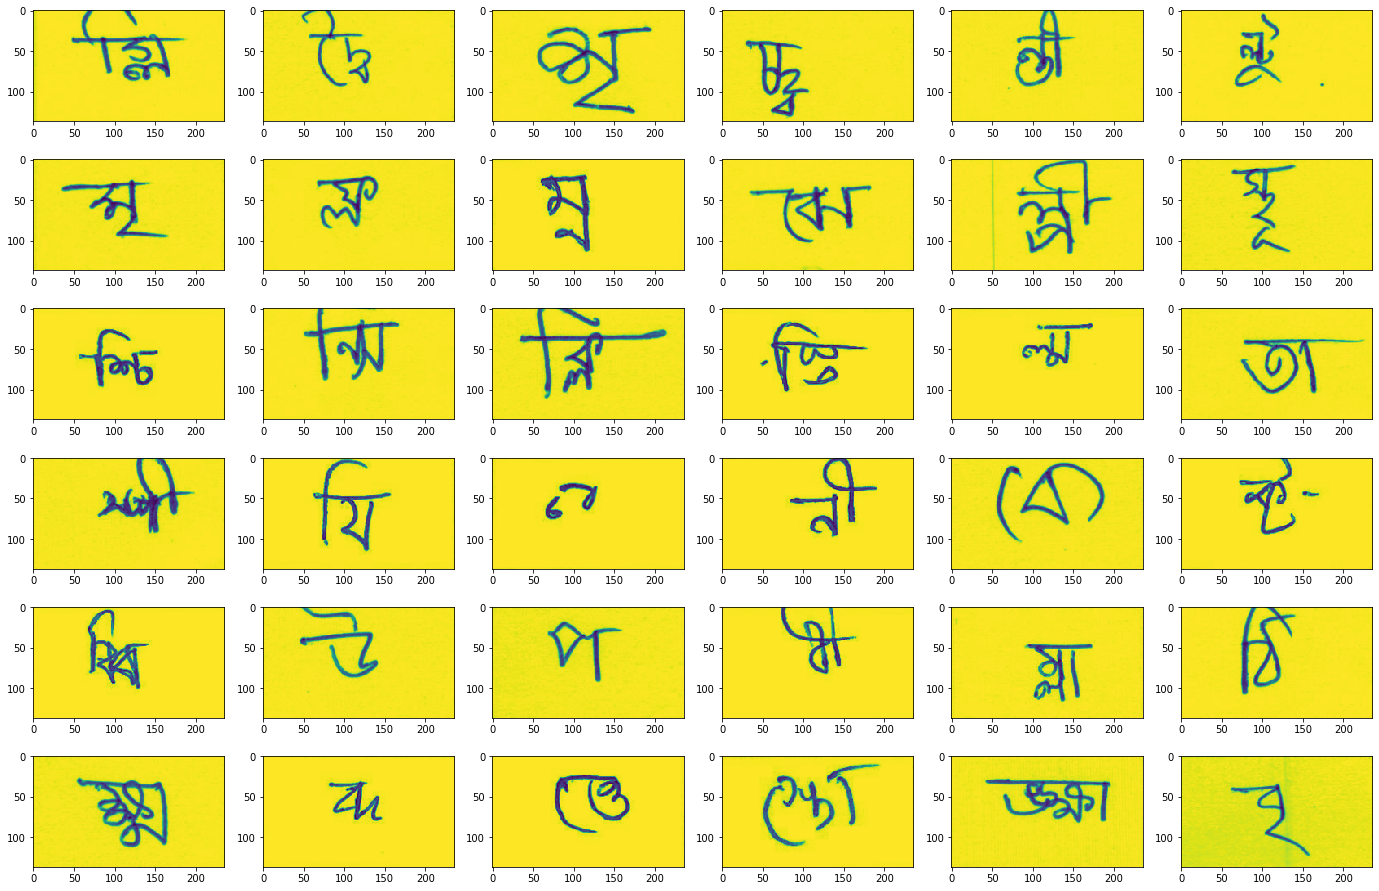

In [29]:
num = 0

print(cons_df.iloc[num]['component'])

fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(24, 16))

count =0
for row in ax:
    for col in row:
        col.imshow(train_df_with_img[train_df_with_img['consonant_diacritic'] == num].drop(columns=['grapheme']).iloc[count].values[:-3].reshape(HEIGHT,WIDTH))
        count += 1
plt.show()


ঁ


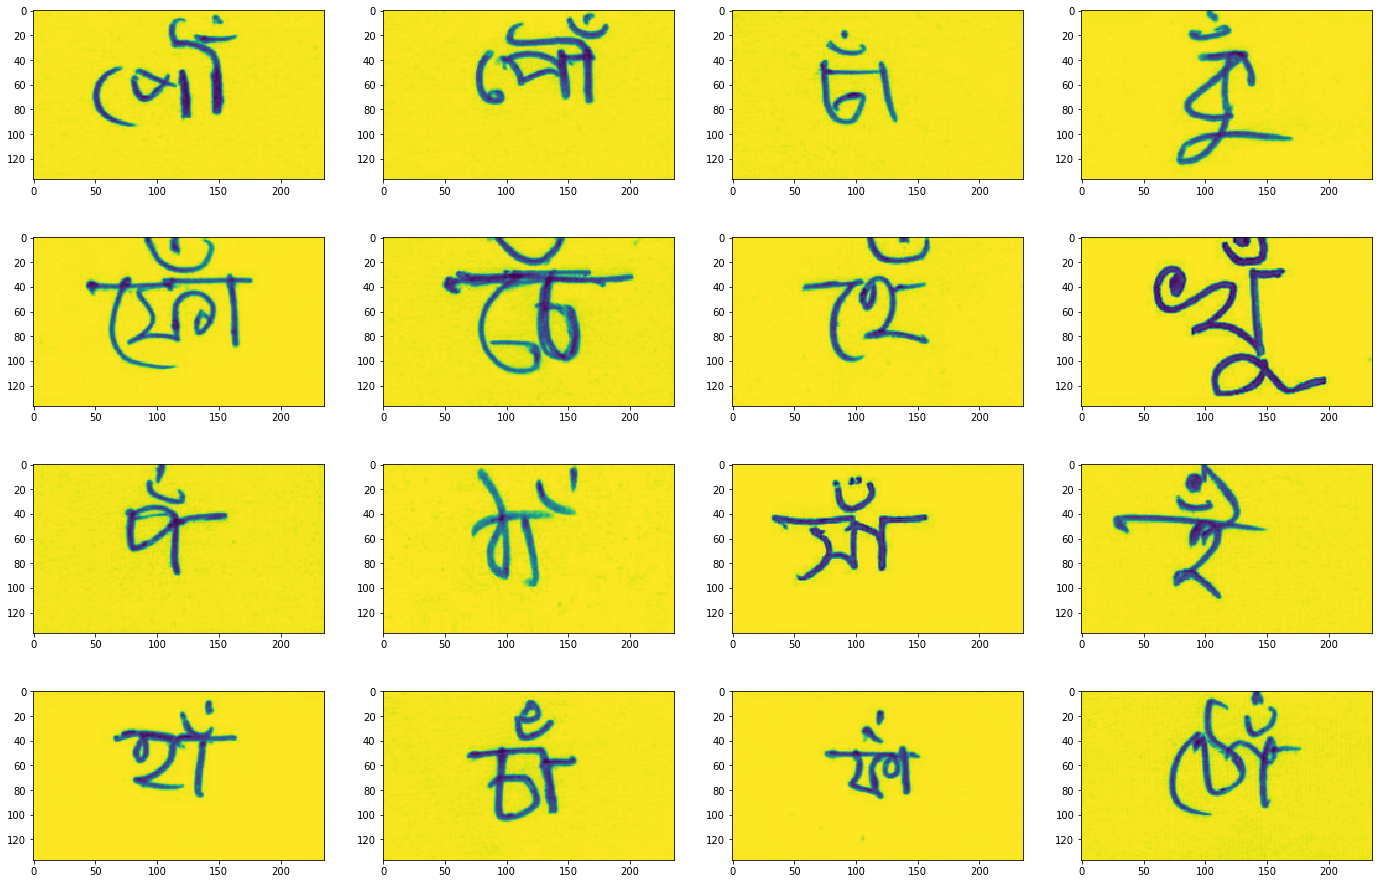

In [30]:
num = 1

print(cons_df.iloc[num]['component'])

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(24, 16))

count =0
for row in ax:
    for col in row:
        col.imshow(train_df_with_img[train_df_with_img['consonant_diacritic'] == num].drop(columns=['grapheme']).iloc[count].values[:-3].reshape(HEIGHT,WIDTH))
        count += 1
plt.show()


র্


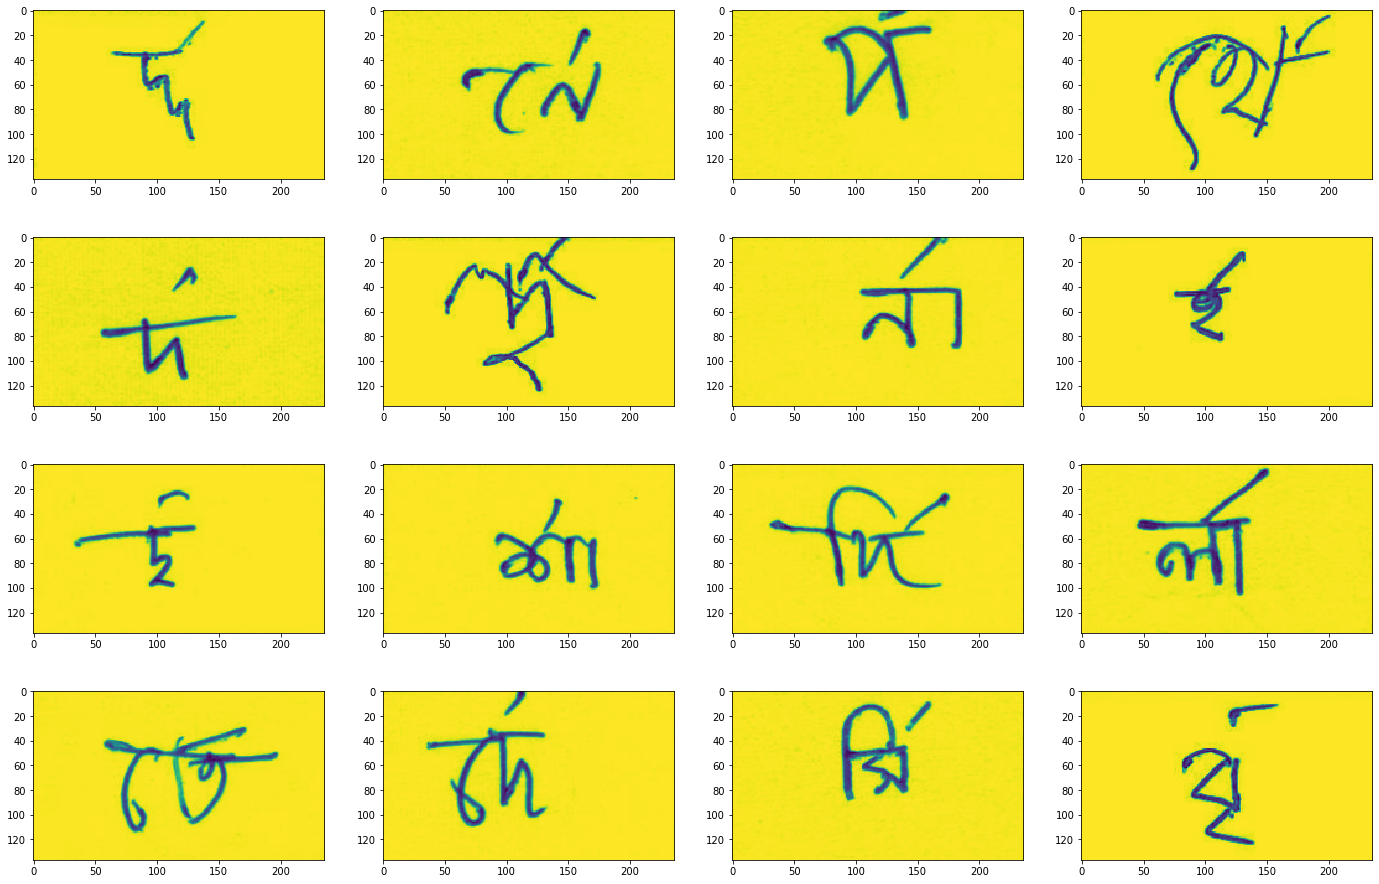

In [31]:
num = 2

print(cons_df.iloc[num]['component'])

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(24, 16))

count =0
for row in ax:
    for col in row:
        col.imshow(train_df_with_img[train_df_with_img['consonant_diacritic'] == num].drop(columns=['grapheme']).iloc[count].values[:-3].reshape(HEIGHT,WIDTH))
        count += 1
plt.show()


## ラベル同士の関係とかみてみる

In [41]:
train_df_with_img[train_df_with_img['grapheme_root'] == 0].drop(columns=['grapheme'])

0    1    2  ...  grapheme_root  vowel_diacritic  consonant_diacritic
1868   250  251  250  ...              0                0                    0
2005   251  252  252  ...              0                0                    0
3354   249  249  249  ...              0                0                    0
5851   248  249  247  ...              0                0                    0
5935   244  248  247  ...              0                0                    0
6528   250  250  247  ...              0                0                    0
7207   247  246  245  ...              0                0                    0
7248   240  241  244  ...              0                0                    0
8062   249  247  248  ...              0                0                    0
9308   247  242  243  ...              0                0                    0
9597   250  249  250  ...              0                0                    0
10091  245  245  246  ...              0                0                    0
11723  250  248  252  ...              0                0                    0
13369  253  252  252  ...              0                0                    0
14105  247  245  247  ...              0                0                    0
15122  251  252  243  ...              0                0                    0
17664  251  249  249  ...              0                0                    0
17747  248  246  246  ...              0                0                    0
18720  254  253  251  ...              0                0                    0
22950  247  249  249  ...              0                0                    0
29031  220  231  231  ...              0                0                    0
29162  252  248  249  ...              0                0                    0
30705  251  251  250  ...              0                0                    0
30870  246  249  249  ...              0                0                    0
31147  250  249  248  ...              0                0                    0
32120  249  248  249  ...              0                0                    0
32459  248  246  245  ...              0                0                    0
35987  250  251  247  ...              0                0                    0
36183  251  251  251  ...              0                0                    0
36646  249  247  247  ...              0                0                    0
37336  255  255  255  ...              0                0                    0
38145  252  254  253  ...              0                0                    0
38696  250  249  249  ...              0                0                    0
38834  252  252  253  ...              0                0                    0
39387  245  250  252  ...              0                0                    0
40953  245  243  245  ...              0                0                    0
42295  248  248  248  ...              0                0                    0
42843  250  249  250  ...              0                0                    0
43456  200  214  217  ...              0                0                    0
44262  246  250  253  ...              0                0                    0
44699  248  249  245  ...              0                0                    0
46248  241  247  246  ...              0                0                    0
46891  248  250  251  ...              0                0                    0
49254  246  246  244  ...              0                0                    0

[44 rows x 32335 columns]

grapheme_rootが0のものは全てvowel_diacriticもconsonant_diacriticも0になる

In [42]:
train_df_with_img[train_df_with_img['grapheme_root'] == 1].drop(columns=['grapheme'])

0    1    2  ...  grapheme_root  vowel_diacritic  consonant_diacritic
2506   253  254  253  ...              1                0                    0
7190   252  251  250  ...              1                0                    0
9456   248  252  249  ...              1                0                    0
10101  251  247  248  ...              1                0                    0
14063  250  246  247  ...              1                0                    0
14950  246  244  242  ...              1                0                    0
15143  249  249  250  ...              1                0                    0
15412  253  253  254  ...              1                0                    0
19660  251  250  251  ...              1                0                    0
19792  254  254  254  ...              1                0                    0
22473  251  249  247  ...              1                0                    0
23127  225  240  242  ...              1                0                    0
25855  252  252  252  ...              1                0                    0
27487  253  254  254  ...              1                0                    0
28147  253  254  254  ...              1                0                    0
30268  254  254  254  ...              1                0                    0
30737  253  254  254  ...              1                0                    0
30853  252  250  249  ...              1                0                    0
37645  254  254  254  ...              1                0                    0
37952  249  250  250  ...              1                0                    0
38529  252  252  252  ...              1                0                    0
39193  249  249  250  ...              1                0                    0
39250  253  253  253  ...              1                0                    0
39293  254  254  254  ...              1                0                    0
40018  255  255  255  ...              1                0                    0
42016  254  253  254  ...              1                0                    0
44214  252  253  253  ...              1                0                    0
44535  248  247  247  ...              1                0                    0
45245  254  254  254  ...              1                0                    0
45251  255  255  255  ...              1                0                    0
45490  254  254  254  ...              1                0                    0
48688  245  248  250  ...              1                0                    0

[32 rows x 32335 columns]

In [45]:
vowel_type =  train_df_with_img[train_df_with_img['grapheme_root'] == 2].drop(columns=['grapheme'])['vowel_diacritic'].value_counts()
print(vowel_type)

consonant_type =  train_df_with_img[train_df_with_img['grapheme_root'] == 2].drop(columns=['grapheme'])['consonant_diacritic'].value_counts()
print(consonant_type)

1    40
0    40
Name: vowel_diacritic, dtype: int64
4    40
0    40
Name: consonant_diacritic, dtype: int64


In [46]:
vowel_type =  train_df_with_img[train_df_with_img['grapheme_root'] == 3].drop(columns=['grapheme'])['vowel_diacritic'].value_counts()
print(vowel_type)

consonant_type =  train_df_with_img[train_df_with_img['grapheme_root'] == 3].drop(columns=['grapheme'])['consonant_diacritic'].value_counts()
print(consonant_type)

0    90
Name: vowel_diacritic, dtype: int64
0    49
1    41
Name: consonant_diacritic, dtype: int64


In [47]:
vowel_type =  train_df_with_img[train_df_with_img['grapheme_root'] == 4].drop(columns=['grapheme'])['vowel_diacritic'].value_counts()
print(vowel_type)

consonant_type =  train_df_with_img[train_df_with_img['grapheme_root'] == 4].drop(columns=['grapheme'])['consonant_diacritic'].value_counts()
print(consonant_type)

0    84
Name: vowel_diacritic, dtype: int64
1    43
0    41
Name: consonant_diacritic, dtype: int64


In [50]:
root_type =  train_df_with_img[train_df_with_img['vowel_diacritic'] == 0].drop(columns=['grapheme'])['grapheme_root'].value_counts()
print(root_type)

consonant_type =  train_df_with_img[train_df_with_img['vowel_diacritic'] == 0].drop(columns=['grapheme'])['consonant_diacritic'].value_counts()
print(consonant_type)

64     217
96     212
107    210
72     207
43     205
      ... 
153     27
37      26
30      25
100     24
137     24
Name: grapheme_root, Length: 155, dtype: int64
0    5844
2    1606
4    1341
5    1053
1     188
3     166
6      97
Name: consonant_diacritic, dtype: int64


In [51]:
root_type =  train_df_with_img[train_df_with_img['vowel_diacritic'] == 1].drop(columns=['grapheme'])['grapheme_root'].value_counts()
print(root_type)

consonant_type =  train_df_with_img[train_df_with_img['vowel_diacritic'] == 1].drop(columns=['grapheme'])['consonant_diacritic'].value_counts()
print(consonant_type)

107    237
13     230
23     230
113    212
103    211
      ... 
21      29
109     29
95      28
120     26
143     23
Name: grapheme_root, Length: 123, dtype: int64
0    4759
4    1664
2    1002
5     952
1     703
6     270
Name: consonant_diacritic, dtype: int64


In [52]:
root_type =  train_df_with_img[train_df_with_img['vowel_diacritic'] == 2].drop(columns=['grapheme'])['grapheme_root'].value_counts()
print(root_type)

consonant_type =  train_df_with_img[train_df_with_img['vowel_diacritic'] == 2].drop(columns=['grapheme'])['consonant_diacritic'].value_counts()
print(consonant_type)

72     162
23     157
96     155
64     143
107    142
      ... 
61      29
98      29
88      28
138     28
62      24
Name: grapheme_root, Length: 114, dtype: int64
0    4300
2     980
5     728
4     329
1     107
Name: consonant_diacritic, dtype: int64
